In [15]:
%matplotlib inline
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from xml.dom import minidom
print("Modules imported")

Modules imported


In [37]:
def get_activity_data(tcx_string):
    """
    Constructs a pandas dataframe from the TCX file passed
    """
    mydoc = minidom.parse(tcx_string)
    trkpt = mydoc.getElementsByTagName("Trackpoint")
    column_names = ["timestamp", "latitude", "longitude", "elevation", "heart_rate", "cadence", "power", "speed"]
    row_list = []

    # parse trackpoint elements. Search for child elements in each trackpoint so they stay in sync.
    for elem in trkpt:
        etimestamp = elem.getElementsByTagName("Time")
        timestamp = None
        for selem in etimestamp:
            timestamp = selem.firstChild.data

        epos = elem.getElementsByTagName("Position")
        elat = None
        elng = None
        for selem in epos:
            elat = selem.getElementsByTagName("LatitudeDegrees")
            lat = None
            for sselem in elat:
                lat = sselem.firstChild.data
            elng = selem.getElementsByTagName("LongitudeDegrees")
            lng = None
            for sselem in elng:
                lng = sselem.firstChild.data

        eelevation = elem.getElementsByTagName("AltitudeMeters")
        elevation = 0.0
        for selem in eelevation:
            elevation = selem.firstChild.data

        eheart = elem.getElementsByTagName("HeartRateBpm")
        eheart_rate = None
        for selem in eheart:
            eheart_rate = selem.getElementsByTagName("Value")
            heart_rate = 0
            for sselem in eheart_rate:
                heart_rate = sselem.firstChild.data

        ecad = elem.getElementsByTagName("Cadence")
        cadence = 0.0
        for selem in ecad:
            cadence = selem.firstChild.data

        eextensions = elem.getElementsByTagName("Extensions")
        ens3 = None
        for selem in eextensions:
            ens3 = selem.getElementsByTagName("ns3:TPX")
            espeed = None
            epower = None
            for sselem in ens3:
                espeed = sselem.getElementsByTagName("ns3:Speed")
                speed = 0.0
                for ssselem in espeed:
                    speed = ssselem.firstChild.data
                epower = sselem.getElementsByTagName("ns3:Watts")
                power = 0.0
                for ssselem in epower:
                    power = ssselem.firstChild.data

        this_row = [timestamp, lat, lng, float(elevation), 
                    float(heart_rate), float(cadence), float(power), float(speed)]
        row_list.append(this_row)

    df = pd.DataFrame(row_list, columns=column_names)
    return df


Text(0, 0.5, 'Power in Watts')

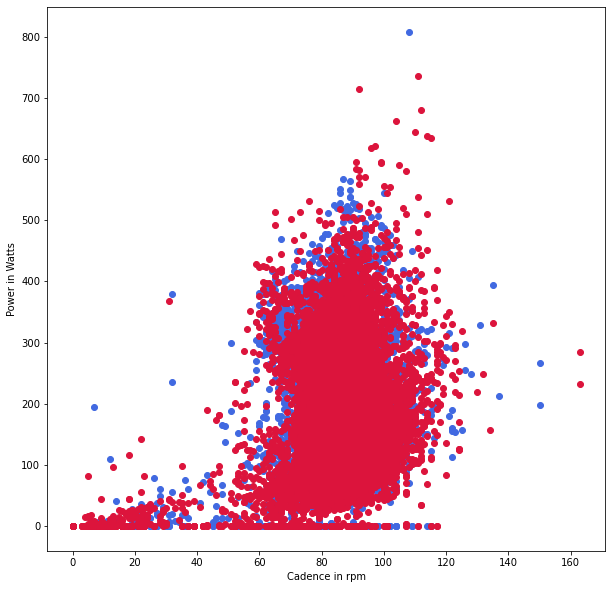

In [38]:
df1 = get_activity_data('Cville10272020.tcx')
df2 = get_activity_data('Bburg10232020.tcx')
cad_data1 = df1["cadence"].to_numpy()
pwr_data1 = df1["power"].to_numpy()
cad_data2 = df2["cadence"].to_numpy()
pwr_data2 = df2["power"].to_numpy()
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.scatter(cad_data1,pwr_data1,c='royalblue')
ax.scatter(cad_data2,pwr_data2,c='crimson')
ax.set_xlabel("Cadence in rpm")
ax.set_ylabel("Power in Watts")
#ax.tick_params(bottom=False,left=False,labelleft=False,labelbottom=False)